### Handling warnings and initial packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
!pip install -q -U watermark
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu121
transformers: 4.35.2



### Title & Configuration

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Exploration

In [5]:
train_path = '/content/train.csv'
test_path = '/content/test.csv'
val_path = '/content/val.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_val = pd.read_csv(val_path)

df_train.drop(df_train.columns.difference(['Data','Label']), 1, inplace=True)
df_test.drop(df_test.columns.difference(['Data','Label']), 1, inplace=True)
df_val.drop(df_val.columns.difference(['Data','Label']), 1, inplace=True)

df_train["Label"] = df_train['Label'].fillna(0).astype(np.int64)
df_test["Label"] = df_test['Label'].fillna(0).astype(np.int64)
df_val["Label"] = df_val['Label'].fillna(0).astype(np.int64)


print("Train data")
df_train.head(30)

Train data


,Data,Label
0,মেকাপ করতে করতে মুখের বর্তমান যে অবস্থা তাতে ম...,2
1,উচ্চবিত্ত পরিবারেও নানা কৌশলে যৌতুক দেয়া এবং ন...,1
2,দিদি সামনের চুল গুলা না রাখলে কী সমস্যা টা হত...,2
3,নষ্টা মেয়ে ছাড়া কখনো সিগারেট খেতে পারে না।,2
4,খানকী গুলা ঢাকা শহর তো নষ্ট করসে এখন কক্সবাজার...,2
5,সব মেয়েরাই ভূত একেকটা!,2
6,অপু তোমার সামনের রাস্তা টা বড় হয়ে গেছে মনে হয় ...,2
7,"দুঃসময়ে প্রথম যে মানুষটি পাশে দাঁড়ায়, চরম সিদ্...",1
8,নারীবান্ধব পরিবেশ তৈরি হয়েছে।,1
9,সবদিক থেকেই দেখা যায় আমাদের দেশের কন্যা-শিশুর...,1


In [6]:
print("Test data")
df_test.head(10)

Test data


,Data,Label
0,"কর্মক্ষেত্রে নারীর অংশগ্রহণ, কাজের পরিবেশ, মজু...",1
1,"এই বেটির বাবা টা যদি ধর্ষক না হইতো,তাহলে আজকে ...",2
2,মানুষ সুন্দর চেহারাকে কুৎসিত চেহারাই কিভাবে উপ...,2
3,ডাক্তারি পড়লে মেয়েকে ভালো বিয়ে দেয়া যাবে,2
4,কাউকে মেরে ফেলার ব্যাপারে সরকারের পদক্ষেপের পে...,0
5,তবে তারা ধীরে ধীরে গাড়ি চালিয়ে আসছে।,0
6,"মায়ের অনুপ্রেরণা, সহযোগিতাতেই আজকের আমার আমি।",1
7,শিক্ষিত মেয়ে মানেই আকাইম্মা,2
8,জামাগুলো খুলে ফেলো বেয়াদব বেটি কোথাকার।,2
9,"হিসাব করে দেখা গিয়েছে, কয়েকশত হাজার বর্গ কিল...",0


In [7]:
print("Validation data")
df_val.head(10)

Validation data


,Data,Label
0,আমি একদম ক্লিয়ার দেখতে পাচ্ছি আফার গোপন দু:খ গ...,2
1,ইনবক্স করলে তোরে জানাবোনে কথা বলে।,0
2,আমাদের সমাজে এখন মেয়েদের চাকরি করার প্রবণতা বে...,2
3,নারীদের ক্রিকেট খেলার কোন অধিকার নেই। এটা অনধি...,2
4,অনেকের মতে আজকের পাবলিক লাইব্রেরীর ধারণা আসলে ...,0
5,স্টেমিনার দিক থেকে পুরুষ নারী থেকে এগিয়ে আছে,2
6,তিনি বলেন তার প্রতিষ্ঠানের ফেসবুক পেইজে অনেকেই...,0
7,এ ঘটনা আমাদের গ্রামেই ঘটতে দেখেছি,0
8,স্কুলের নাটকগুলোতে অংশ নেবার সময়েই নিজের এই স...,0
9,সেটাই তো স্তন না দুললে ভূমিকম্প কেমনে হবে?,2


In [8]:
df_train=df_train.dropna()
df_train.shape

(8921, 2)

In [9]:
df_train[:]

,Data,Label
0,মেকাপ করতে করতে মুখের বর্তমান যে অবস্থা তাতে ম...,2
1,উচ্চবিত্ত পরিবারেও নানা কৌশলে যৌতুক দেয়া এবং ন...,1
2,দিদি সামনের চুল গুলা না রাখলে কী সমস্যা টা হত...,2
3,নষ্টা মেয়ে ছাড়া কখনো সিগারেট খেতে পারে না।,2
4,খানকী গুলা ঢাকা শহর তো নষ্ট করসে এখন কক্সবাজার...,2
...,...,...
8919,"ফলে, সিন্টোইয়া ইচ্ছাকৃতভাবে জনকে খুন করে, প্র...",0
8920,মাগী বাল ছাল ছবি আপলোড দিয়া নতুন ভার্জিন পোলা ...,2
8921,"মেয়ে তো সিনেমায় কাজ করে, ওতো এম্নিই যার তার সা...",2
8922,এভাবে একটি সিদ্ধান্তে পোঁছাতে পারবে এই সিস্টেমটি।,0


In [10]:
df_test=df_test.dropna()
df_test.shape

(987, 2)

In [11]:
df_test[:]

,Data,Label
0,"কর্মক্ষেত্রে নারীর অংশগ্রহণ, কাজের পরিবেশ, মজু...",1
1,"এই বেটির বাবা টা যদি ধর্ষক না হইতো,তাহলে আজকে ...",2
2,মানুষ সুন্দর চেহারাকে কুৎসিত চেহারাই কিভাবে উপ...,2
3,ডাক্তারি পড়লে মেয়েকে ভালো বিয়ে দেয়া যাবে,2
4,কাউকে মেরে ফেলার ব্যাপারে সরকারের পদক্ষেপের পে...,0
...,...,...
983,বিশেষ করে আমাদের সমাজের মেয়েরা স্বামীর উপার্জন...,2
984,কত অদ্ভুত প্রকারের মানুষ যে আছে এই গ্রুপটাতে ন...,0
985,তারা ধর্ষণ করে ঐ গার্মেন্ট শ্রমিককে।,0
986,পুরুষরা নারীকে কখনো সমকক্ষ ভাবে না।,1


In [12]:
df_val=df_val.dropna()
df_val.shape

(1261, 2)

In [13]:
df_val[:]

,Data,Label
0,আমি একদম ক্লিয়ার দেখতে পাচ্ছি আফার গোপন দু:খ গ...,2
1,ইনবক্স করলে তোরে জানাবোনে কথা বলে।,0
2,আমাদের সমাজে এখন মেয়েদের চাকরি করার প্রবণতা বে...,2
3,নারীদের ক্রিকেট খেলার কোন অধিকার নেই। এটা অনধি...,2
4,অনেকের মতে আজকের পাবলিক লাইব্রেরীর ধারণা আসলে ...,0
...,...,...
1257,ছাগীদের আরেক নাম নারীবাদী।,2
1258,ডিভোর্সী মেয়ে বিয়ে করার চেয়ে মরে যাওয়াও ভালো।,2
1259,আফা যৌবন তো লাল টমেটো বানাইয়া হালাইছেন তাইলে।,2
1260,সৌদি আরবে পৌঁছে তিনি সোভিয়েত-সৌদি সম্পর্ককে আ...,0


In [14]:
df_train['Label'].value_counts()

2    3199
0    2959
1    2763
Name: Label, dtype: int64

In [15]:
df_test['Label'].value_counts()

2    375
1    306
0    306
Name: Label, dtype: int64

In [16]:
df_val['Label'].value_counts()

2    451
1    418
0    392
Name: Label, dtype: int64

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921 entries, 0 to 8923
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    8921 non-null   object
 1   Label   8921 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 209.1+ KB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 987
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    987 non-null    object
 1   Label   987 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.1+ KB


In [19]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 0 to 1261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    1261 non-null   object
 1   Label   1261 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.6+ KB


In [20]:
class_names = ['neutral', 'positive','negative']

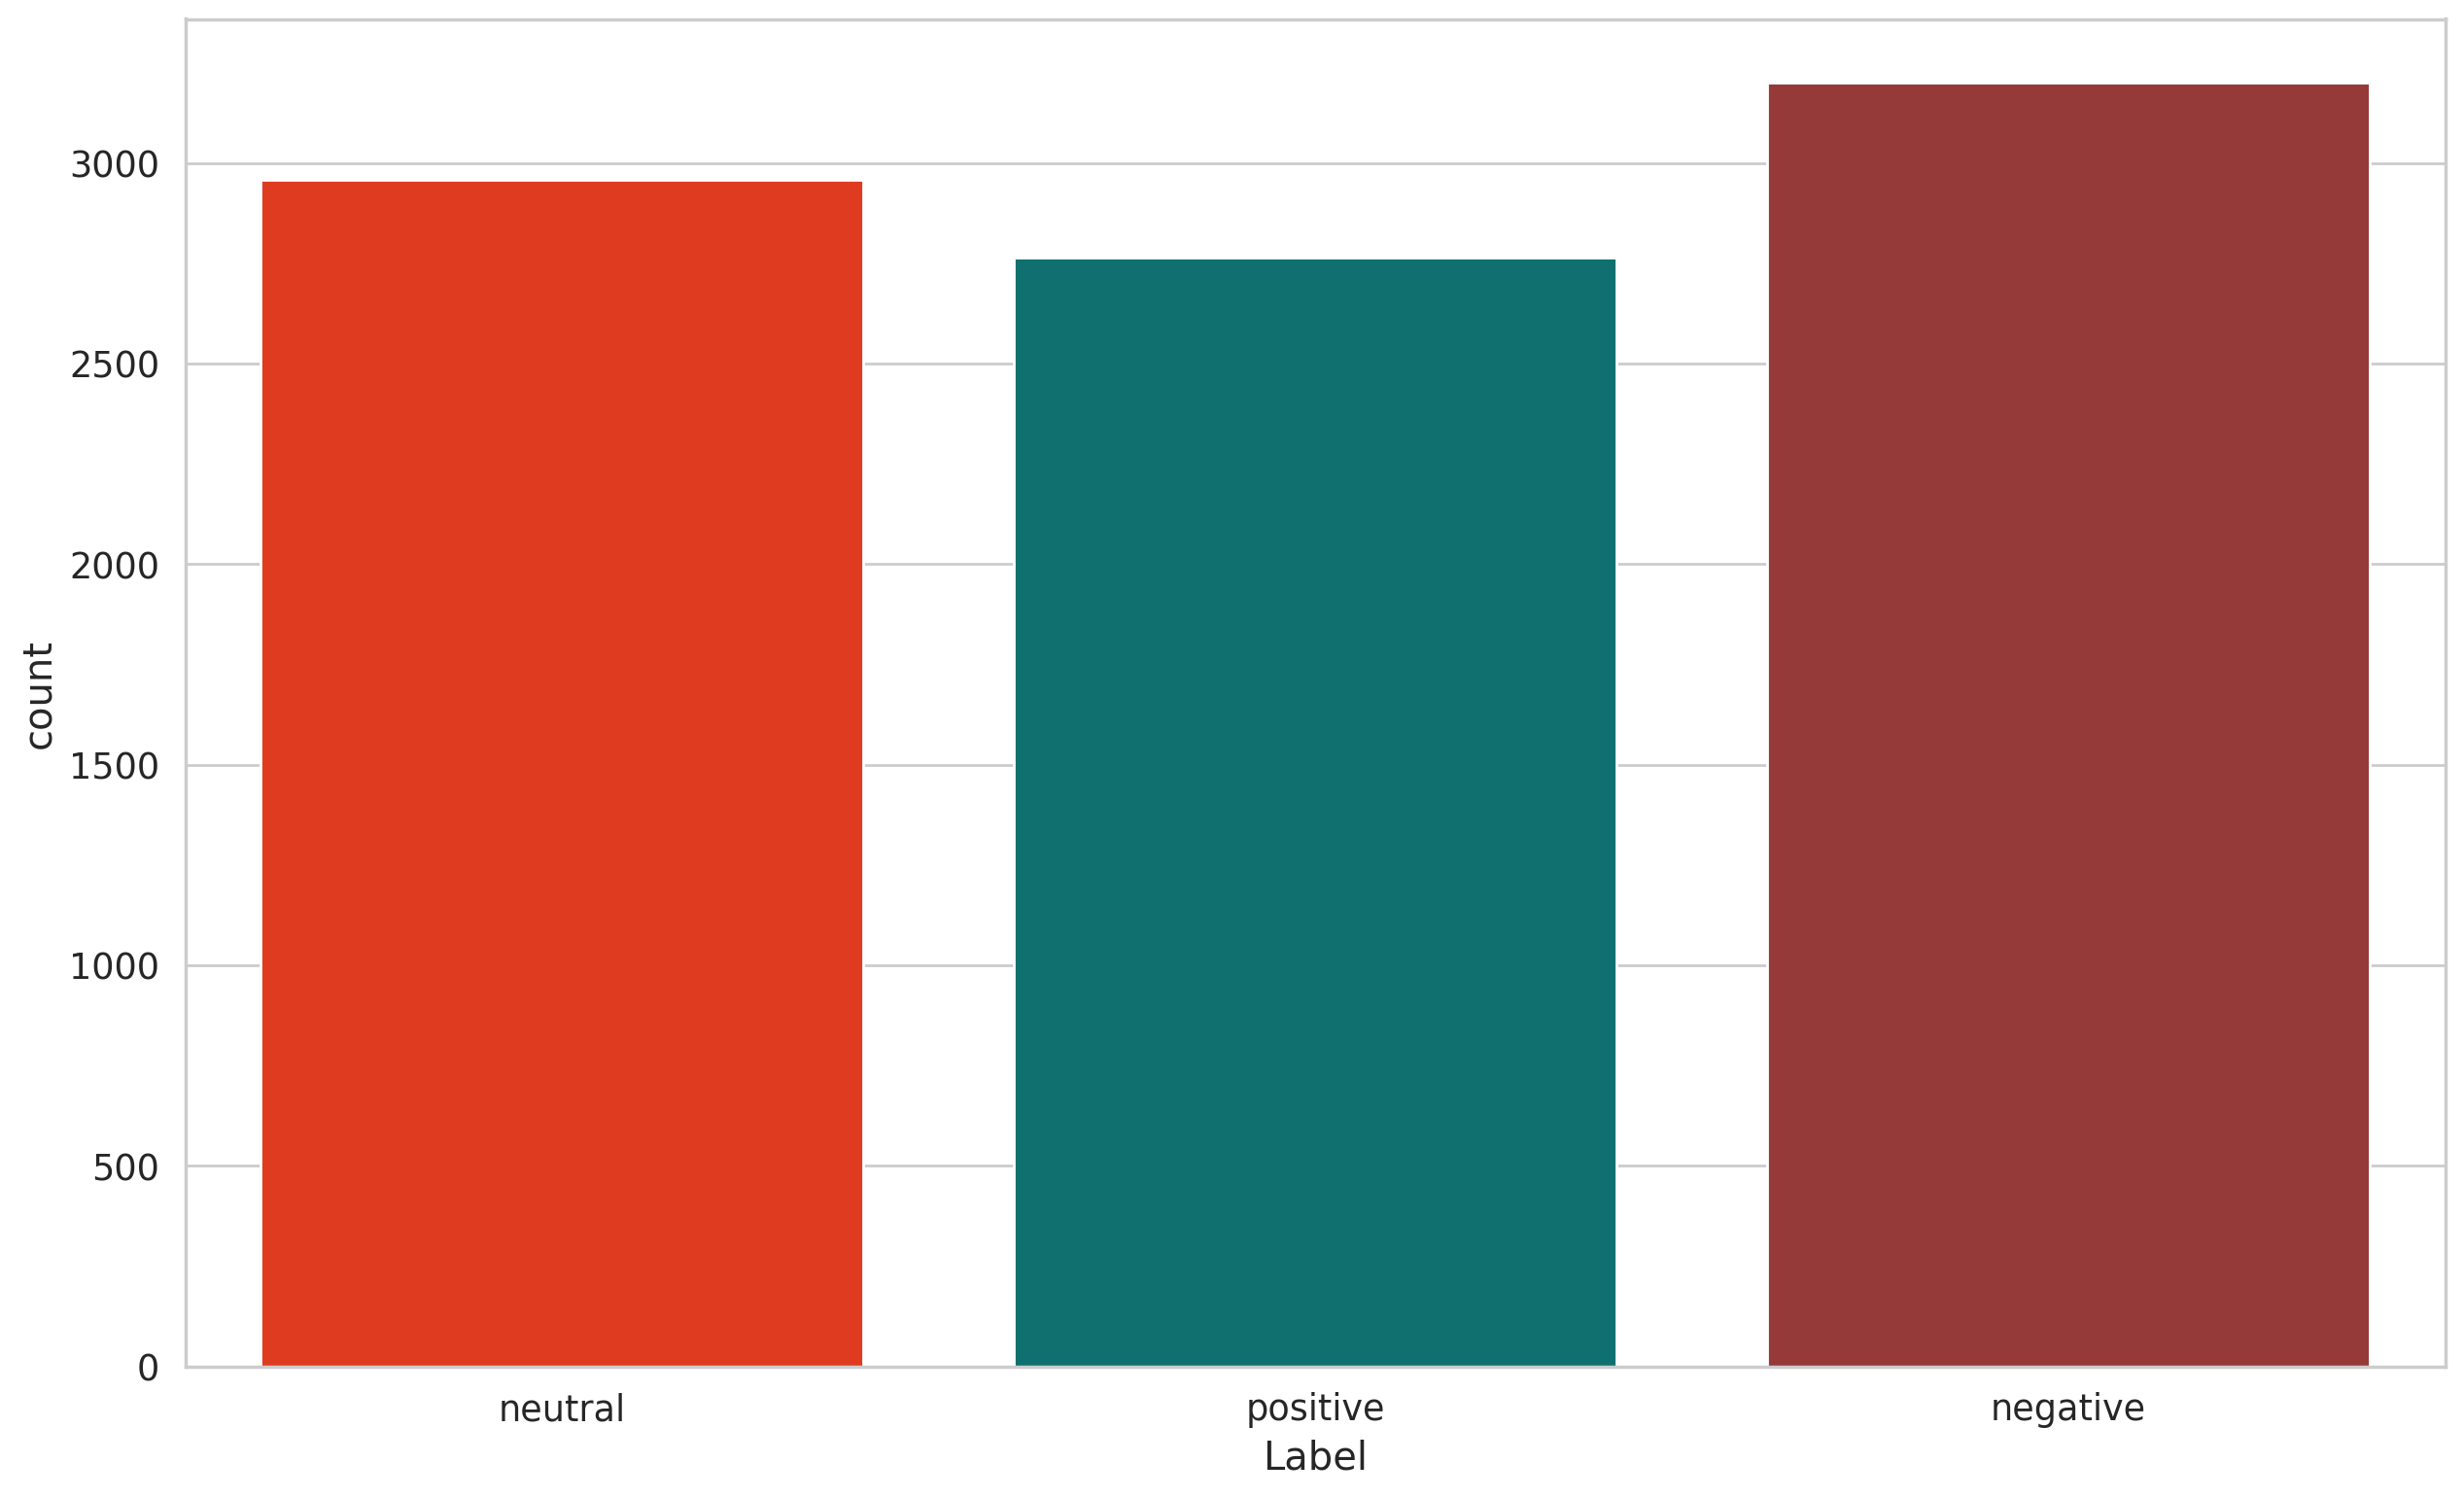

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(15, 9))

Toxic_count = df_train['Label'].value_counts()
sns.countplot(x='Label', data=df_train, hue='Label', palette=['#FF2400', 'teal', '#A52A2A', 'Seagreen'], legend=False)
labels = class_names
plt.gca().set_xticklabels(labels)

plt.show()


### Import Banglabert packages

In [22]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [23]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert' #sagorsarker/bangla-bert-base #bert-base-multilingual-cased #csebuetnlp/banglabert #neuropark/sahajBERT

In [24]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")#BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) #AutoTokenizer.from_pretrained("csebuetnlp/banglabert") PreTrainedTokenizerFast.from_pretrained("neuropark/sahajBERT")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [25]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-lqjc_jhb
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-lqjc_jhb
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=3e4e1c3508109c430cdf129fa0b8393b00518ea9936c026ed466f5fcbb1b847b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0gjbfuu4/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186460 sha256=84b08575d03c5a11cc3ff734972633473f9d423

In [26]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize
import torch

In [27]:
MAX_LEN = 80

In [28]:
sample_txt= "আমি একদম ক্লিয়ার দেখতে পাচ্ছি"

In [29]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

#### Choosing Sequence Length

In [30]:
token_lens = []

for txt in df_train.Data:
    txt = normalize(txt)  # This normalization step is required before tokenizing the text
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


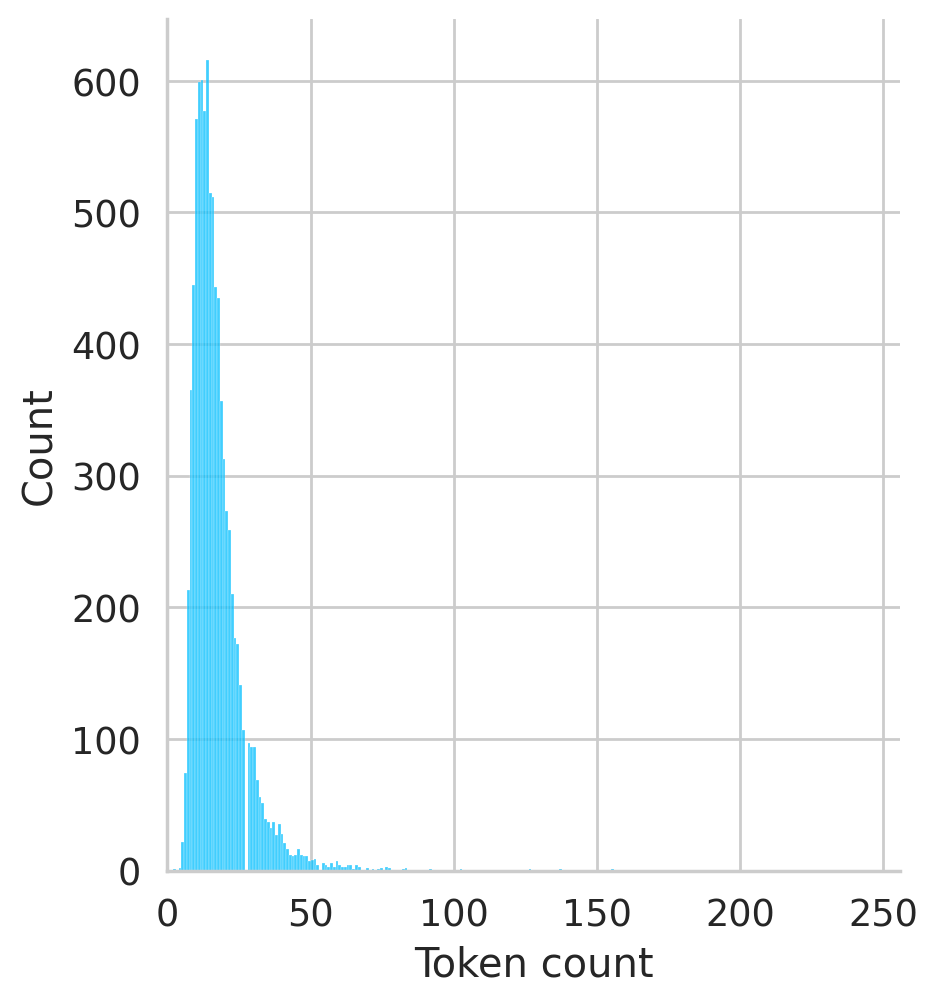

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming token_lens is a list of token counts
sns.displot(token_lens, kde=False)
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.show()

In [32]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Data': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [33]:
df_train.shape, df_val.shape, df_test.shape

((8921, 2), (1261, 2), (987, 2))

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Data.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )


In [35]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [36]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

dict_keys(['Data', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 80])
torch.Size([64, 80])
torch.Size([64])


In [39]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME) #BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [40]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [41]:
torch.cuda.empty_cache()

In [42]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [43]:
PRE_TRAINED_MODEL_NAME

'csebuetnlp/banglabert'

In [44]:
bert_model.config.hidden_size

768

In [45]:
last_hidden_state

ElectraForPreTrainingOutput(loss=None, logits=tensor([[-10.6180,  -3.1433,  -2.4670,   0.2849,  -3.4841,  -3.0480, -10.6181,
          -0.2494,  -0.0517,  -0.6464,  -1.7271,  -1.7865,  -0.8170,  -1.3560,
           0.0299,   0.7829,   0.7557,   2.0890,  -0.2304,   0.1178,  -0.9789,
           3.4368,   1.5699,   0.2463,   0.5140,   0.4415, -10.7468,  -1.1602,
          -0.6470,  -0.7607,  -4.0054,   0.0293,  -1.3348,  -4.0220,  -4.1570,
          -0.4818,  -3.7450,  -7.7298,  -1.8813,  -1.8794,  -0.7807,  -2.4238,
          -1.0560,   0.3710,  -1.8764,   0.2527, -10.7313, -10.5477,   0.0387,
          -0.4149,   0.9826,  -0.9389,   2.6853,   3.3343,  -4.0777,   0.3230,
          -3.2623, -10.5658,  -3.9119,  -0.7865,  -0.3537,  -2.0726,  -3.1930,
          -3.6292,  -4.0831,   0.1141, -10.5354, -10.5795,  -3.2874,   0.1619,
          -0.5057,  -1.6379,  -0.9556,   3.9639,  -2.5629,   1.1007,  -2.0315,
          -8.2157,  -0.0188,  -0.7232]], grad_fn=<SqueezeBackward1>), hidden_states=N

In [46]:
class genderBiasClassifier(nn.Module):

    def __init__(self, n_classes):
        super(genderBiasClassifier, self).__init__()
        self.electra = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(80, n_classes)  # Adjust the input size

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.logits  # Access logits for pooled output
        output = self.drop(pooled_output)
        return self.out(output)

In [47]:
model = genderBiasClassifier(len(class_names))
model = model.to(device)

In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 80])
torch.Size([64, 80])


In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[9.8595e-01, 1.2524e-02, 1.5229e-03],
        [9.9999e-01, 6.6509e-06, 6.5788e-08],
        [9.8901e-01, 1.5019e-03, 9.4893e-03],
        [2.2755e-02, 1.2873e-02, 9.6437e-01],
        [7.5072e-01, 2.2981e-01, 1.9468e-02],
        [9.9149e-03, 2.8802e-04, 9.8980e-01],
        [3.2330e-02, 7.6373e-02, 8.9130e-01],
        [9.9520e-01, 8.4913e-05, 4.7182e-03],
        [1.3510e-01, 1.3193e-03, 8.6358e-01],
        [3.6384e-01, 1.1634e-03, 6.3499e-01],
        [9.6806e-01, 3.0872e-02, 1.0714e-03],
        [4.0218e-01, 9.6591e-03, 5.8816e-01],
        [8.8381e-01, 3.4686e-02, 8.1500e-02],
        [1.0807e-01, 3.2854e-01, 5.6338e-01],
        [7.3805e-02, 4.0019e-01, 5.2601e-01],
        [5.9608e-01, 8.3249e-02, 3.2067e-01],
        [9.9963e-01, 4.4649e-05, 3.2774e-04],
        [9.9638e-01, 6.3007e-05, 3.5577e-03],
        [2.4574e-02, 3.6518e-03, 9.7177e-01],
        [7.9757e-03, 3.9903e-03, 9.8803e-01],
        [9.9881e-01, 5.0481e-05, 1.1419e-03],
        [4.9652e-02, 3.7154e-08, 9

## Training the model

In [50]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [51]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Update tqdm description with the current loss
    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.8884355332170214 accuracy 0.6332249747786123


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.3625476032495499 accuracy 0.873116574147502

Epoch 2/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.3160356820694038 accuracy 0.8876807532787805


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.2862241189926863 accuracy 0.9032513877874703

Epoch 3/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.1987737405513014 accuracy 0.9296043044501738


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.3434871919453144 accuracy 0.9072164948453608

Epoch 4/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.12183959003138756 accuracy 0.9577401636587827


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.43805972710251806 accuracy 0.8897700237906423

Epoch 5/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.08386134589756174 accuracy 0.9707431902253111


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.48272047732025386 accuracy 0.9008723235527359

Epoch 6/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.04811040242950964 accuracy 0.9846429772447035


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.6020472651347518 accuracy 0.9111816019032514

Epoch 7/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.033949670999988614 accuracy 0.9892388745656318


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.7441888607107103 accuracy 0.9111816019032514

Epoch 8/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.023896216178919922 accuracy 0.9930501064903038


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.9004160657525062 accuracy 0.8945281522601111

Epoch 9/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.015492098648857271 accuracy 0.9948436273960319


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.9492445692420006 accuracy 0.9199048374306106

Epoch 10/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.012053137757139407 accuracy 0.996525053245152


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.113432025909424 accuracy 0.9040444091990484

Epoch 11/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.009573173368120738 accuracy 0.9971976235848


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.077805656194687 accuracy 0.9111816019032514

Epoch 12/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.00881030099014879 accuracy 0.998094384037664


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.0059513926506043 accuracy 0.9143536875495638

Epoch 13/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.004743689776216188 accuracy 0.99831857415088


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.2365277618169785 accuracy 0.9064234734337827

Epoch 14/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.006025467162587565 accuracy 0.99831857415088


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.2369159311056137 accuracy 0.9095955590800952

Epoch 15/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.00337657292565195 accuracy 0.999103239547136


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.1860378205776214 accuracy 0.9119746233148295

Epoch 16/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.002387373990031451 accuracy 0.999327429660352


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.1597423911094666 accuracy 0.9151467089611419

Epoch 17/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.0022536517684895382 accuracy 0.999551619773568


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.2493467777967453 accuracy 0.9119746233148295

Epoch 18/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.002936109252557882 accuracy 0.999103239547136


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.1939507491886616 accuracy 0.9119746233148295

Epoch 19/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.002879350528317762 accuracy 0.999663714830176


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.1762553125619888 accuracy 0.9143536875495638

Epoch 20/20
----------


Training:   0%|          | 0/140 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.0009088060727252513 accuracy 0.999663714830176


Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.2029341727495193 accuracy 0.9135606661379857

CPU times: user 24min 23s, sys: 12min 37s, total: 37min
Wall time: 38min 1s


In [54]:
model=genderBiasClassifier(len(class_names))

In [55]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

## Evaluation

In [72]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati

0.916919959473151

In [73]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["Data"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

In [74]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

### Classification report

In [75]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

     neutral     0.9553    0.9085    0.9313       306
    positive     0.8952    0.9216    0.9082       306
    negative     0.9055    0.9200    0.9127       375

    accuracy                         0.9169       987
   macro avg     0.9187    0.9167    0.9174       987
weighted avg     0.9178    0.9169    0.9171       987



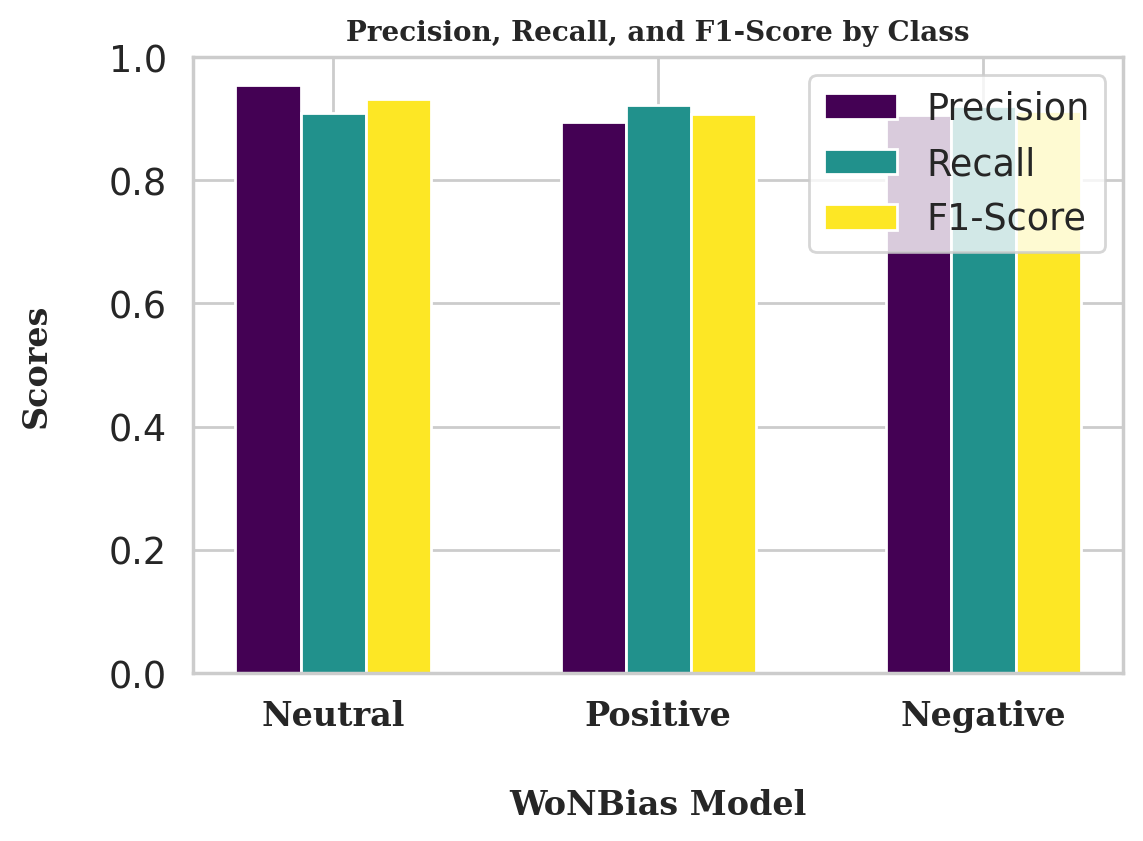

In [124]:
from matplotlib.cm import viridis
# Calculate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract class labels
classes = list(report.keys())[:-3]  # Removing 'micro avg', 'macro avg', 'weighted avg' keys

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Map class labels to specific categories
class_labels = []
for class_label in classes:
    if class_label == '0':
        class_labels.append('Neutral')
    elif class_label == '1':
        class_labels.append('Positive')
    elif class_label == '2':
        class_labels.append('Negative')

# Extract precision, recall, f1-score, and support from the classification report
precision = [report[class_label]['precision'] for class_label in classes]
recall = [report[class_label]['recall'] for class_label in classes]
f1_score = [report[class_label]['f1-score'] for class_label in classes]
support = [report[class_label]['support'] for class_label in classes]

x = np.arange(len(classes))  # the label locations
width = 0.2  # the width of the bars


# Get colors from the viridis colormap
colors = viridis(np.linspace(0, 1, 3))

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - width, precision, width, label='Precision', color=colors[0])
rects2 = ax.bar(x, recall, width, label='Recall', color=colors[1])
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score', color=colors[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores',fontdict=font,labelpad=20)
ax.set_title('Precision, Recall, and F1-Score by Class',fontdict=font2)
ax.set_xticks(x)
ax.set_xticklabels(class_labels,fontdict=font)  # Use modified class labels
ax.legend()
ax.set_ylim(0, 1.0)
plt.xlabel('WoNBias Model', fontdict=font,labelpad=20)

plt.show()


#### Confusion Matrix

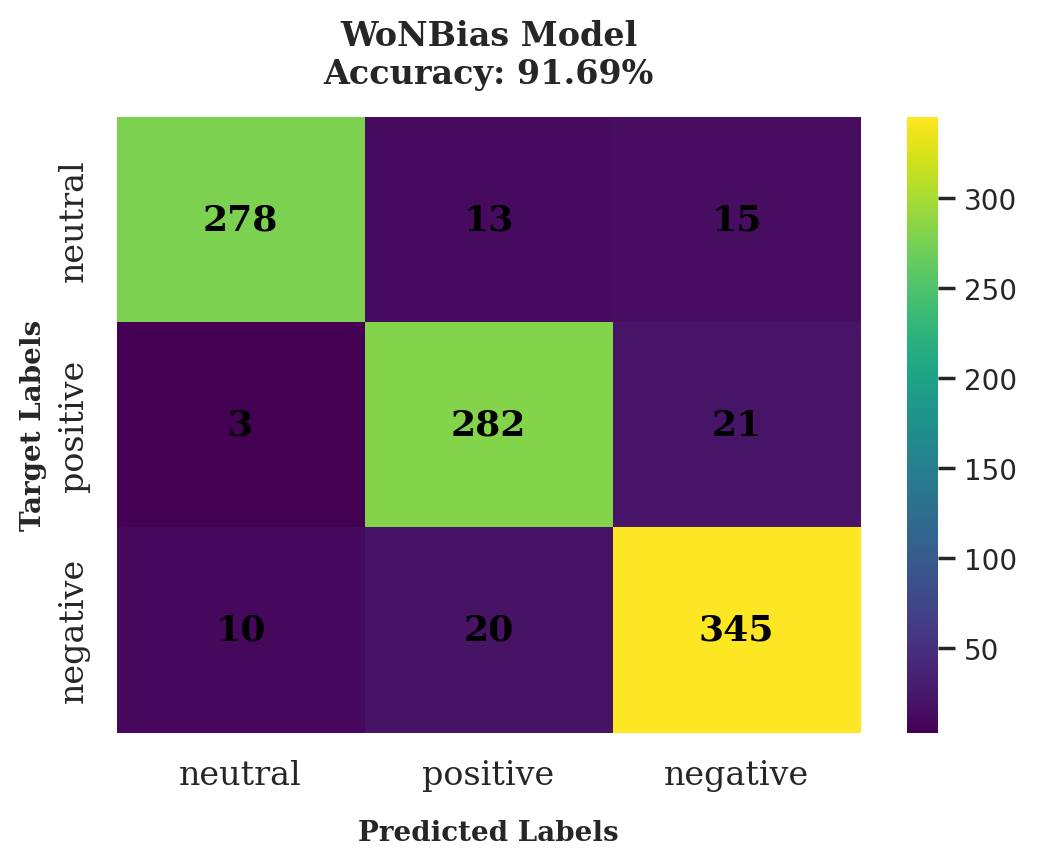

In [128]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="viridis",
                      xticklabels=class_names, yticklabels=class_names,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('WoNBias Model\nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()

In [78]:
idx = 40

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [79]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

নাগরিক সেবায় এমন বিলাসিতা কোনোভাবেই সর্বসাধারণের জন্য প্রযোজ্য না
হওয়ায়, পরিকল্পনাটিতে পরিবর্তন আনা হয়।

True Label: neutral


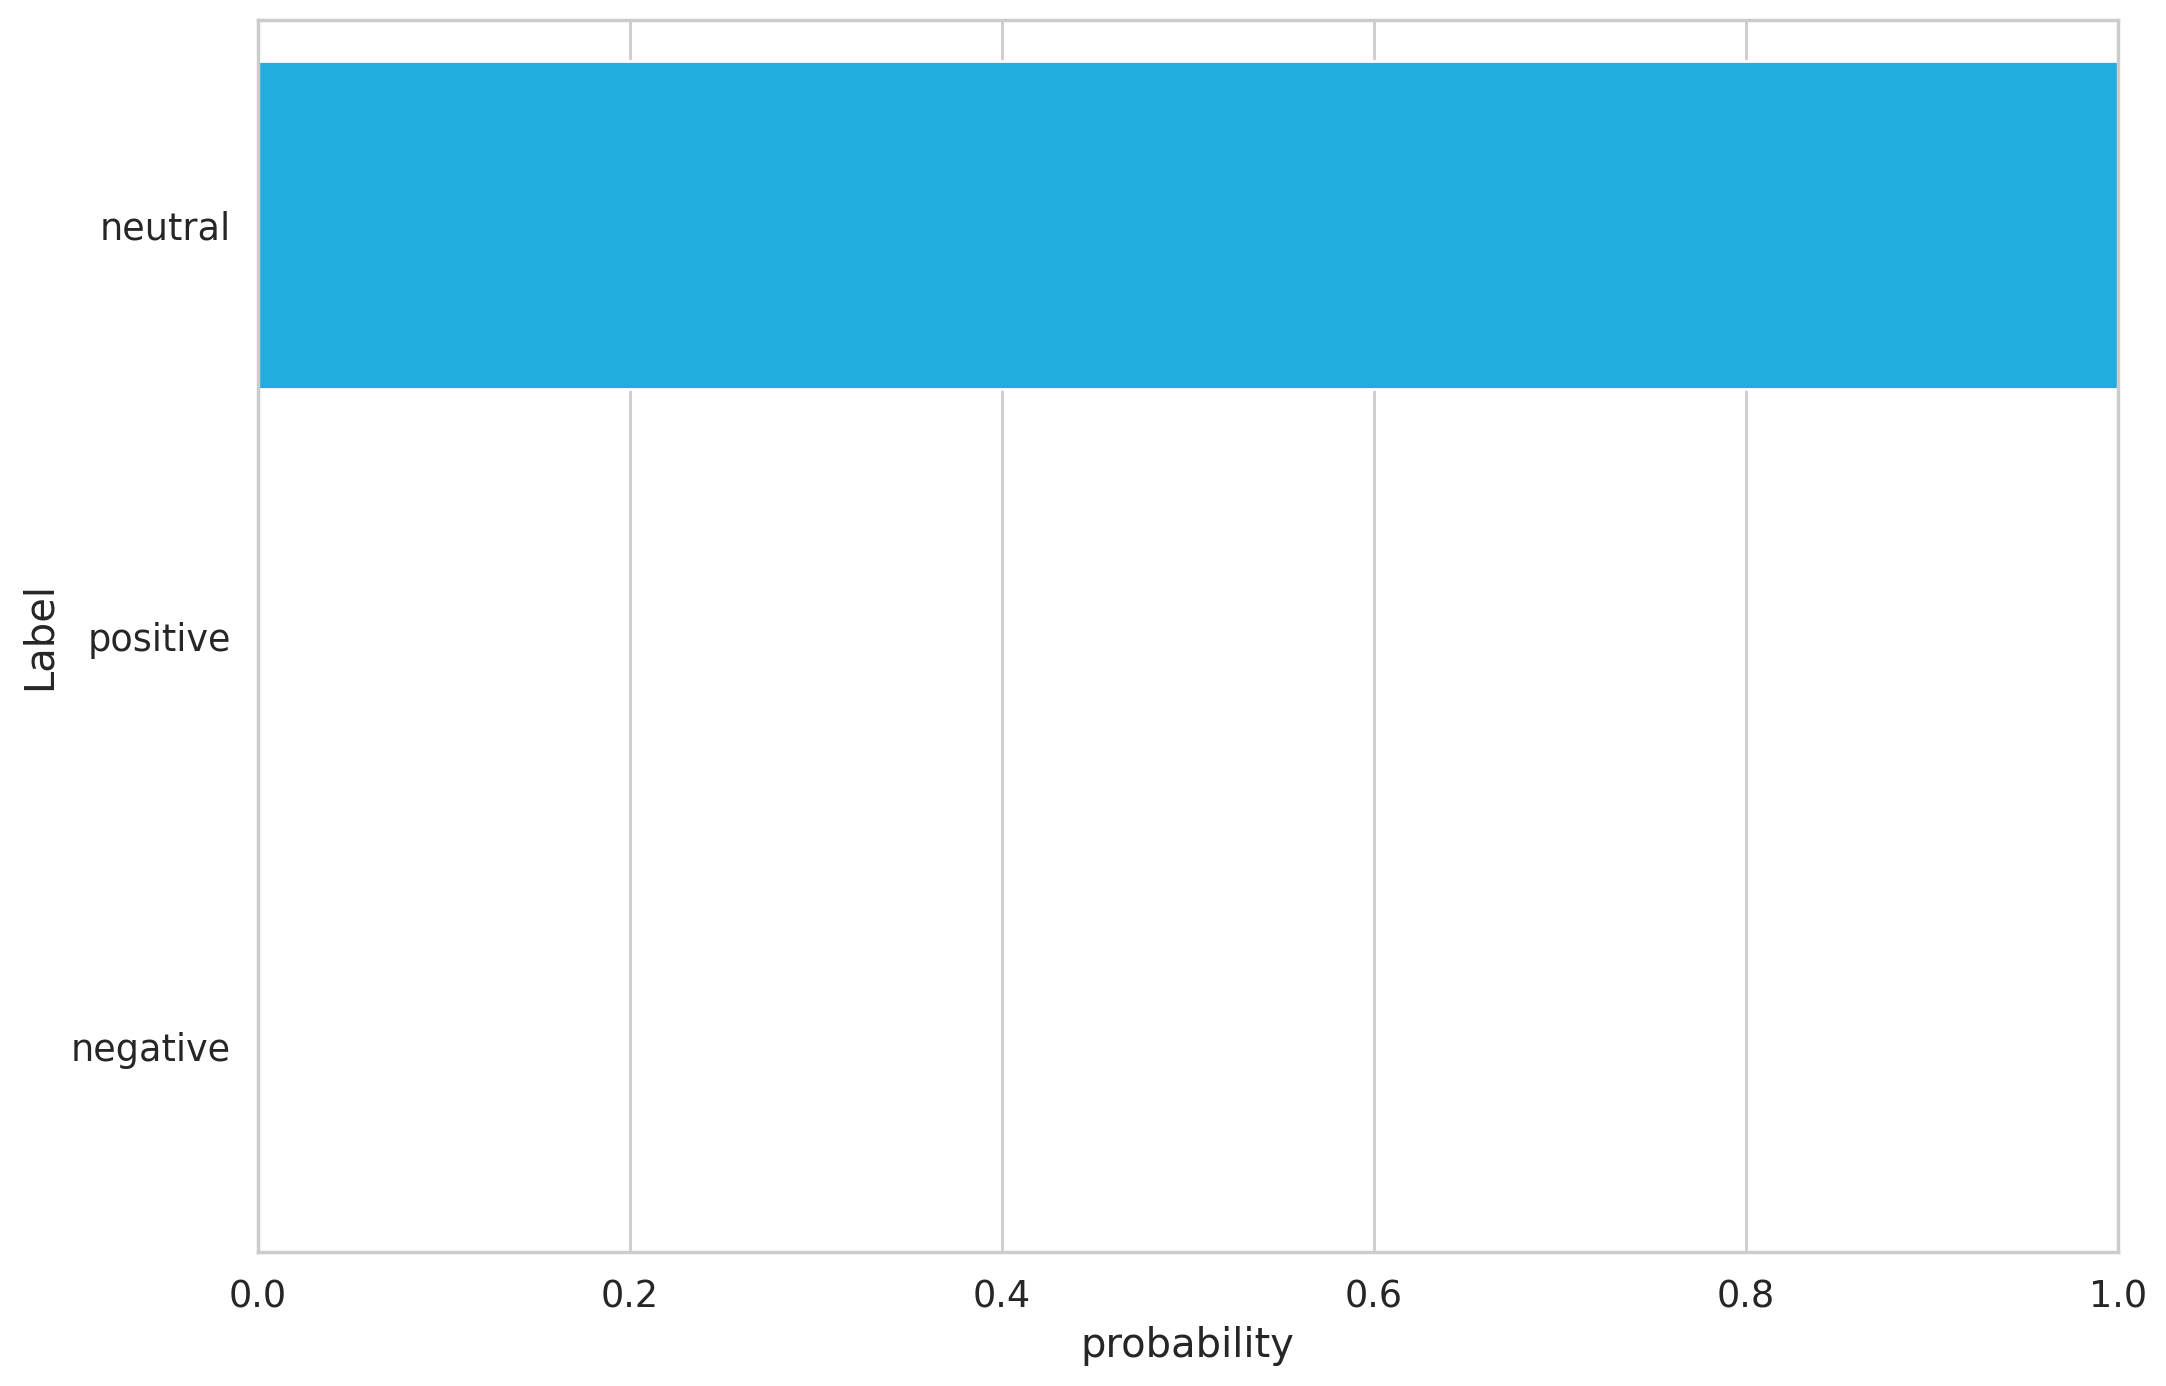

In [80]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Label')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [117]:
Raw_Text = "তিনি অনেক ভালো লেখেন"

In [118]:
encoded_review = tokenizer.encode_plus(
  Raw_Text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [119]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text: {Raw_Text}')
print(f'Prediction  : {class_names[prediction]}')

Raw Text: তিনি অনেক ভালো লেখেন
Prediction  : neutral


In [120]:
review_text = "মেয়েরা এসব পারে না"

In [121]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [122]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Context text: {review_text}')
print(f'Prediction   : {class_names[prediction]}')

Context text: মেয়েরা এসব পারে না
Prediction   : negative
